
**Remark: please answer each question in its own cell.**

On Quercus, submit both a PDF printout of your assignment (for easier grading) and the ipynb file.

# **Sentiment Analysis Using Gated-Recurrent Neural Networks**

In this assignment, we will use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database (IMDB) website. The label of each movie review is either positive or negative. An example of the input-output pair in this dataset is

"*I happen to run into this movie one night so I decided to watch it ! I was very pleased with the movie ... I thought it was a wonderful plot . It 's a great feeling knowing a deceased one has come back and you get that second chance to say what you want to say ! And this wife stayed devoted for 23 years ! ! ! I thought it was a great movie ! !*"

where its label, as you might expect, is 
"*positive*".

**In this assignment, we want to design a classifier that takes as input a review and outputs whether it is a positive or negative review about a movie.**

In the next two cells, we import some modules and also fix some constants for our implementation. 

In [1]:
import csv
from typing import Callable, Tuple

import jax.numpy as jn
import matplotlib.pyplot as plt
import numpy as np
from jax import lax
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tqdm import trange
from sklearn.model_selection import train_test_split
%pip --quiet install objax
import objax
from objax.typing import JaxArray


objax.random.DEFAULT_GENERATOR.seed(42)
np.random.seed(42)

     |████████████████████████████████| 50 kB 2.6 MB/s 


In [2]:
!gdown --id 11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7

Downloading...
From: https://drive.google.com/uc?id=11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7
To: /content/IMDB Dataset.csv
100% 66.2M/66.2M [00:00<00:00, 182MB/s]


In [3]:
max_vocab = 2000  # this parameter is for the maximum number of words in the "dictionary"
max_len = 200  # maximum length of each review
embedding_size = 30  # size of embedding
num_hidden_units_GRU = 30  # GRU cells in the RNN layer
num_hidden_units = 60  # hidden unit of dense network after GRU

vocab_size = max_vocab
filename = 'IMDB Dataset.csv'

# How to find a representation of sentences?
In order to put the words into the machine learning algorithm the text data should be converted into a vector representation. The first approach that comes to mind is *one hot encoding*.
 # One Hot Encoding
Assume that we count the number of English words in the Merriam-Webster dictionary, and it turns out that the total number of words is $N$. Then, a possible way to represent the words is to use binary vectors of size $N$. Each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a $1$.
As an example let's say all the words in the dictionary consists of $\{$apple, orange, Milan,Rome$\}$. For this example, the one hot encoding is given by:
 
apple = $[1,0,0,0]$ \\
orange = $[0,1,0,0]$ \\
Milan = $[0,0,1,0]$  \\
Rome = $[0,0,0,1]$
 
We can also represent each word by an integer: for instance in the above-mentioned example, the mapping is apple $\rightarrow$ 1, orange $\rightarrow$ 2, Milan $\rightarrow$ 3,  Rome $\rightarrow$ 4.
 



When we are working with a dataset, a practical approach for one-hot encoding of the data is as follows:
 
1.  First, we can create a dictionary which shows each word along with its frequency in the dataset. For example, if the sentence is "Put the books on the table." , we need to create a dictionary such that word_index["Put"] = 1; word_index["the"] = 2; word_index["books"] = 1; word_index["on"] = 1; word_index["table"] = 1.
2.  Second, based on the maximum size of the vocabulary we want, we can sort the words based on their frequency and only pick the most frequent words of this maximum size of the vocabulary, and this creates our dictionary. So lower integer means more frequent word (often the first few are stop words because they appear a lot)
 
3. Then, we can assign an integer to each word in the dictionary, and represent each sentence as a sequence of integers.
 
 
The following function performs the above-mentioned steps for our IMDB dataset.



In [4]:
def data_processing(filename, max_vocab, max_len):
  # filename: the name of the .csv file
  # max_vocab: The maximum number of words
  # max_len: 
  messages = []  # a list contains the reviews
  labels = []  # a list contains the labels
  with open(filename, 'r') as file:
      reader = csv.reader(file)
      firstline = True
      for row in reader:
        if firstline:
            firstline = False
            continue
        else:
            messages.append(row[0])
            labels.append(int(row[1]=='positive'))

  tokenizer = Tokenizer(num_words=max_vocab)
  tokenizer.fit_on_texts(messages)
  messages_seq = tokenizer.texts_to_sequences(messages)
  data = pad_sequences(messages_seq, maxlen=max_len)  
  train_size = 0.8
  messages_train, messages_valid_test, labels_train, labels_valid_test  = train_test_split(data, labels, train_size=train_size)
  messages_valid, messages_test, labels_valid, labels_test  = train_test_split(messages_valid_test, labels_valid_test, train_size=0.5)
  return np.array(messages_train), np.array(labels_train), np.array(messages_valid), np.array(labels_valid), np.array(messages_test), np.array(labels_test)

For the data_processing function, we used Tokenizer which is a class in keras.preprocessing.text. The following questions are about the different methods in this class. \\



**Question 1** [1 points]: In your own words, explain what does "fit_on_texts" do? \\

This method updates the internal vocabulary based on a list of texts. In other words, it creates a vocabulary `word_index` for the given list of texts based on the frequency of each word in the text. Each entry of the list is assumed to be a token.



**Question 2** [1 points]: In your own words, explain what does "texts_to_sequences" do? \\

This method updates the vocabulary based on a list of sequences. Since the method `fit_on_texts(texts)` needs to be called before `texts_to_sequences` is called, `texts_to_sequences` replaces each text in texts with its corresponding index number in the `word_index` dictionary.

**Question 3** [1 points]: In your own words, explain what does "pad_sequences" do, and why do we need it? \\

This method pads sequences (i.e.: sentences) to the same length. For sentences which are shorter than `max_len` words long, the sequences are padded with value until they are `max_len` long. For sentences which are longer than `max_len` words long, they are truncated to be `max_len` long. 

We use this function because different sentences in a given text could be of different length (ex: "I liked this movie. The action sequences were really well executed"), and padding allows us to use the same `word_index` dictionary for both sentences. 

In the next cell, we encode the data set using one-hot encoding, and split the dataset into the training set, validation set, and the test test.

In [5]:
messages_train, labels_train, messages_valid, labels_valid, messages_test, labels_test = data_processing(filename, max_vocab, max_len)

**Question 4** [1 points]: Print one of the input in the training set and explain your observation? Does it match with what you expected?

In [6]:
print("messages_train[0]: {}".format(messages_train[0]))
print("len(messages_train[0]): {}".format(len(messages_train[0])))
print("labels_train[0]: {}".format(labels_train[0]))

messages_train[0]: [ 634   12  239  110  846   36  172   30  224  196    1  434  365   55
    3  279    7    7  157 1726  190    6    1  738 1993    1 1180    4
 1882    2  146  145    3  226    4    3  207  326    2  145 1077   16
   88    4  132   18   10  154   99    4    1  300   11   17  989   36
    1  495  492  250   73   76  106  106  696   60   85 1057 1343    5
  229  132   23   31  138  212 1133   14   31    3    2    8   11    6
    3  448   14  619    4    1  719    1 1245    2   73    1  164 1514
    1 1239    5 1674    1  888 1261    5    1  309  140    2  410  624
    7    7    1  272    6 1010    5   26   39   14 1378  217   65    2
   46    6   30  224   27  191 1473    8 1088   18   10   84    1  227
   66  358   68   54   27    5   15   44   21  193    5    3  879 1773
   22   25    5  160  197  176    3  111   12 1569  472   75  221    5
  327    2   35   23   51   71 1890   14    9 1388   11   19    6    3
   16   61    1  469  533    2    3  171 1776    5  586   

In the first review, there are 200 words and the elements are the index of the word in `word_index`. Since `labels_train[0]` = 0, the first message is a negative review. 

This matches what was expected.

# Embedding Layer



Imagine that we have 80,000 unique words in a text classification problem and we select to preprocess the text as explained above. For instance, a sentence "i love you" or ['i', 'love', 'you'] can be shown as a matrix of size (3 , 80000) where its elements is all zeros except from 3 elements that correspond to those words. In the case that we want to extract the feature using recurrent neural network, the input size should be the size of $80,000$ in which only three entries are non-zero!

Instead, we can use the observation that since our goal is to extract feature from a sentence, we might be able to construct a mapping so that the words whose meanings are similar map to the same vector. One possible approach to do this is to perform this mapping using a simple matrix multiplication that transforms words into their corresponding word embeddings or turns positive integers (indexes) into dense vectors of fixed size, where the size of embedding $\ll$ size of the vocabualry. 

Please watch this short video to gain better understanding of the embedding layer:


https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s


Since Objax does not have embedding layer module in it, we need to write our own module. One implementation of the embedding layer is as follows. 

In [7]:
class Embed(objax.Module):
    def __init__(self, size: int, latent: int, init: Callable = objax.nn.init.xavier_truncated_normal):
        self.w = objax.TrainVar(init((size, latent)))

    def __call__(self, x: JaxArray) -> JaxArray:
        return self.w.value[x]

**Question 5: [1 points]**  Briefly explain how `__init__` and `__call__` functions work when the input is a sentence?

`__init__` creates a `TrainVar` which keeps track of the trainable weights of the neural network.

`__call__` performs a mapping, where the value of the weight for a variable vector `x` is matrix multiplied with `x`

# Gated Recurrent Unit Cell
GRUs are a family of the recurrent neural networks used for processing of the sequential data. In this assignment, we want to use GRU for the sentiment analysis.

The forward pass of a Gated Recurrent Unit is defined by the following equations:




1.   $z_t = \text{sigmoid} (W_z x_t + U_z h_{t-1} + b_z)$
2.   $r_t = \text{sigmoid} (W_r x_t + U_r h_{t-1} + b_r)$
3.   $\hat{h}_t = \text{tanh} (W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)$
4.   $h_t =  (1-z_t)\odot h_{t-1} + z_t \odot \hat{h}_t$

where
the operator ${\displaystyle \odot }$  denotes the Hadamard product, and 

*  $x_{t}$: input vector
*   $h_{t}$: output vector
* ${\hat {h}}_{t}$: candidate activation vector
* $z_{t}$: update gate vector
* $r_{t}$: reset gate vector
* $W_z$, $W_r$, $W_h$ , $U_z$, $U_r$, $U_h$, $b_z$ ,$b_r$, $b_h$ are parameter matrices and vectors.





The schematic of a GRU cell is show below (taken from Wikipedia). Here $\hat{y}_t$ is the same as $h_t$, and $\sigma$ is sigmoid function.

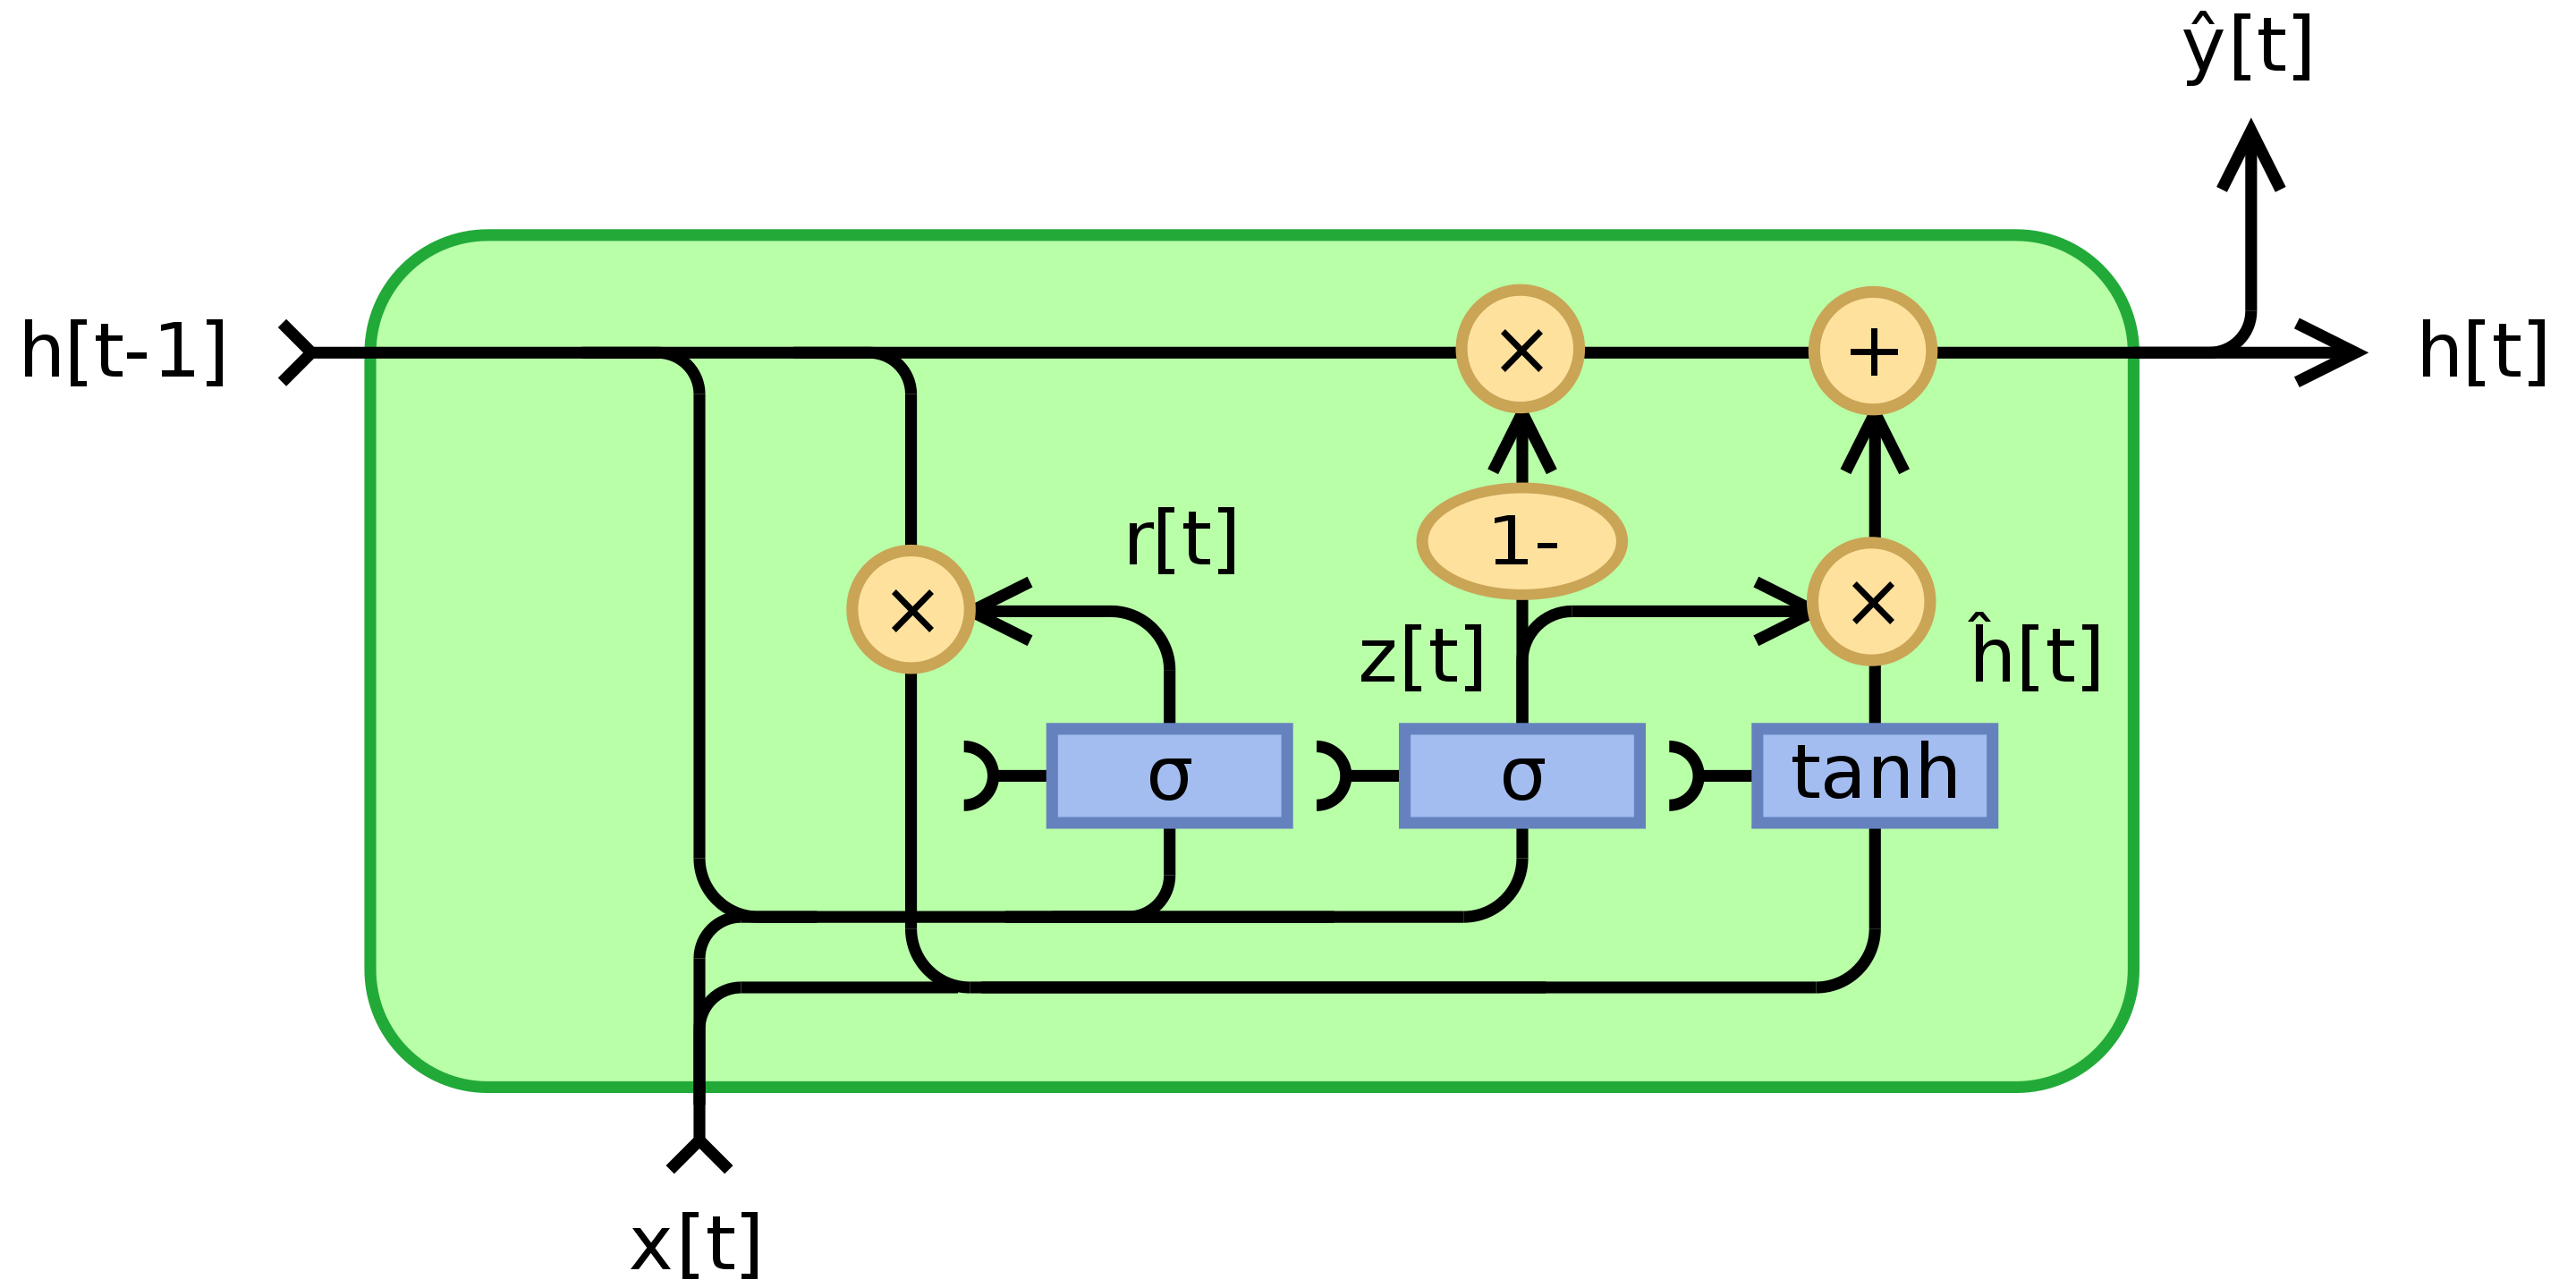

To learn more about GRU, please watch these short videos:

https://www.coursera.org/lecture/intro-to-deep-learning/modern-rnns-lstm-and-gru-WpduX

https://www.youtube.com/watch?v=pYRIOGTPRPU

Similar to the embedding layer, GRU module is not implemented in the Objax. The following is an implementation of the GRU cell in the Objax.

**Question 6 [3 points]:** In the following implementation, complete the `__call__` function. 

In [8]:
class GRU(objax.Module):
    def __init__(self, nin: int, nout: int,
                 init_w: Callable = objax.nn.init.xavier_truncated_normal,
                 init_b: Callable = objax.nn.init.truncated_normal):
        self.update_w = objax.TrainVar(init_w((nin, nout)))
        self.update_u = objax.TrainVar(init_w((nout, nout)))
        self.update_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.reset_w = objax.TrainVar(init_w((nin, nout)))
        self.reset_u = objax.TrainVar(init_w((nout, nout)))
        self.reset_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.output_w = objax.TrainVar(init_w((nin, nout)))
        self.output_u = objax.TrainVar(init_w((nout, nout)))
        self.output_b = objax.TrainVar(init_b((nout,), stddev=0.01))

    def __call__(self, x: JaxArray, initial_state: JaxArray) -> Tuple[JaxArray, JaxArray]:
        def scan_op(state: JaxArray, x: JaxArray) -> JaxArray:  # State must come first for lax.scan
        # state = ht, x = input
            # fill this in
            # update gate = zt = sigmoid(Wz * xt + Uz * h(t-1) + bz)
            update_gate = objax.functional.sigmoid(jn.dot(x, self.update_w.value) + jn.dot(state, self.update_u.value) + self.update_b.value)
            
            # fill this in
            # reset gate = rt = sigmoid(Wr * xt + Ur * h(t-1) + br)
            reset_gate = objax.functional.sigmoid(jn.dot(x, self.reset_w.value) + jn.dot(state, self.reset_u.value) + self.reset_b.value)
            
            # fill this in
            # candidate activation function = ht_hat = tanh(Wh * xt + Uh * (rt ⊙ h(t−1)) + bh
            output_gate =  objax.functional.tanh(jn.dot(x, self.output_w.value) + \
                                                jn.dot((reset_gate * state), self.output_u.value) + self.output_b.value)
            
            #return update_gate * state + (1 - update_gate) * output_gate, 0  # we don't use the output, return 0.
            # output: ht=(1−zt)⊙h(t−1)+zt⊙h^t
            return (1-update_gate) * state + (update_gate) * output_gate, 0   # we don't use the output, return 0.

        return lax.scan(scan_op, initial_state, x.transpose((1, 0, 2)))[0]

**Questions 7** (bonus)[5 points]: With an example, explain in detail what does lax.scan function do, and what it is useful for?

`lax.scan` allows us to quickly compile the for loop in an RNN (and related architectures such as LSTMs and GRUs) by providing a loop with a carryover. Carryover means that the previous states' values are propagated to the current timestamp, to be used in the current timestamp's associated functions. 

Using `lax.scan` versus other loop carry methods such as `lax.fori_loop` or `np.cumsum` is more efficient because JAX can use more efficient differentiation code. This is because less data from the forward pass needs to be stored for use in the backward pass. If the desired data is in a loop carry, we need to save the whole loop carry for each iteration, but `lax.scan` allows us to keep track of a slice of the loop for each iteration. 

For example, consider the cumulative sum code implemented in `lax.scan` below

In [9]:
import time

a = jn.arange(0, 10, 2) # a = [0, 2, 4, 6, 8]

# cumulative sum using lax.scan()

# define a function that does the cumulative sum
def cumsum(res, el):
    """
    'res': The result from the previous loop.
    'el': The current array element.
    """
    res = res + el
    return res, res  # ("carryover", "stored")

result_init = 0

start_time = time.time()
final, result = lax.scan(cumsum, result_init, a)
print("lax.scan took {} to run".format(time.time() - start_time))
print(result)

lax.scan took 0.23393774032592773 to run
[ 0  2  6 12 20]


In the `cumsum` function above, the result `res` from the previous loop is carried over to the next iteration of the loop, and it is also stored as an element in an answer array. In this manner, at an array index `i`, `res` is both the answer in terms of the cumulative sum up to that point, and the value that is used to calculate the cumulative sum at array index `i+1`

References

https://github.com/google/jax/discussions/3850

https://ericmjl.github.io/dl-workshop/02-jax-idioms/02-loopy-carry.html

https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html

https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html

# The classifier 

The structure of the proposed classifier is as follows:


*   The input is a vector whose elements are integers in the interval $\{$1,...,max_vocab$\}$ of length max_len. In fact input is the one-hot encoding of each review.
*    Then, the embedding layer converts this vector into a matrix of size (max_len,embedding_size).
* Then, we feed each row of this matrix into the GRU cell. The size of the output vector of the GRU is num_hidden_units_GRU.
*  The output of the GRU is feed into a fully-connected layer with num_hidden_units neurons and ReLU activation function.

* Finally, we have the output layer which is a fully-connected layer with two outputs corresponding to the positive or negative label.



**Question 8** [3 points]: implement the described classifier using `objax.nn.Sequential`.




In [10]:
# fill this in:
# https://objax.readthedocs.io/en/latest/notebooks/Custom_Networks.html#Custom-Model-Definition
gru_rnn = objax.nn.Sequential([
    # embedding layer
    Embed(max_len, embedding_size),

    # GRU layer
    GRU(embedding_size, num_hidden_units_GRU),

    # fully connected layer
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),

    # feed through ReLU activation
    objax.functional.relu,

    # output
    objax.nn.Linear(num_hidden_units, 2),
])

You can print the structure as well as the number of the parameters of the each layer using the following line of codes.

In [11]:
print(f'{" Network ":-^79}')
print(gru_rnn.vars())

----------------------------------- Network -----------------------------------
(Sequential)[0](Embed).w          6000 (200, 30)
(Sequential)[1](GRU).update_w      900 (30, 30)
(Sequential)[1](GRU).update_u      900 (30, 30)
(Sequential)[1](GRU).update_b       30 (30,)
(Sequential)[1](GRU).reset_w       900 (30, 30)
(Sequential)[1](GRU).reset_u       900 (30, 30)
(Sequential)[1](GRU).reset_b        30 (30,)
(Sequential)[1](GRU).output_w      900 (30, 30)
(Sequential)[1](GRU).output_u      900 (30, 30)
(Sequential)[1](GRU).output_b       30 (30,)
(Sequential)[2](Linear).b           60 (60,)
(Sequential)[2](Linear).w         1800 (30, 60)
(Sequential)[4](Linear).b            2 (2,)
(Sequential)[4](Linear).w          120 (60, 2)
+Total(14)                       13472


**Question 9** [3 points]: Draw the classifier architecture diagram. For GRU consider drawing the unrolled version. You do not need to draw the internal structure of the GRU. 

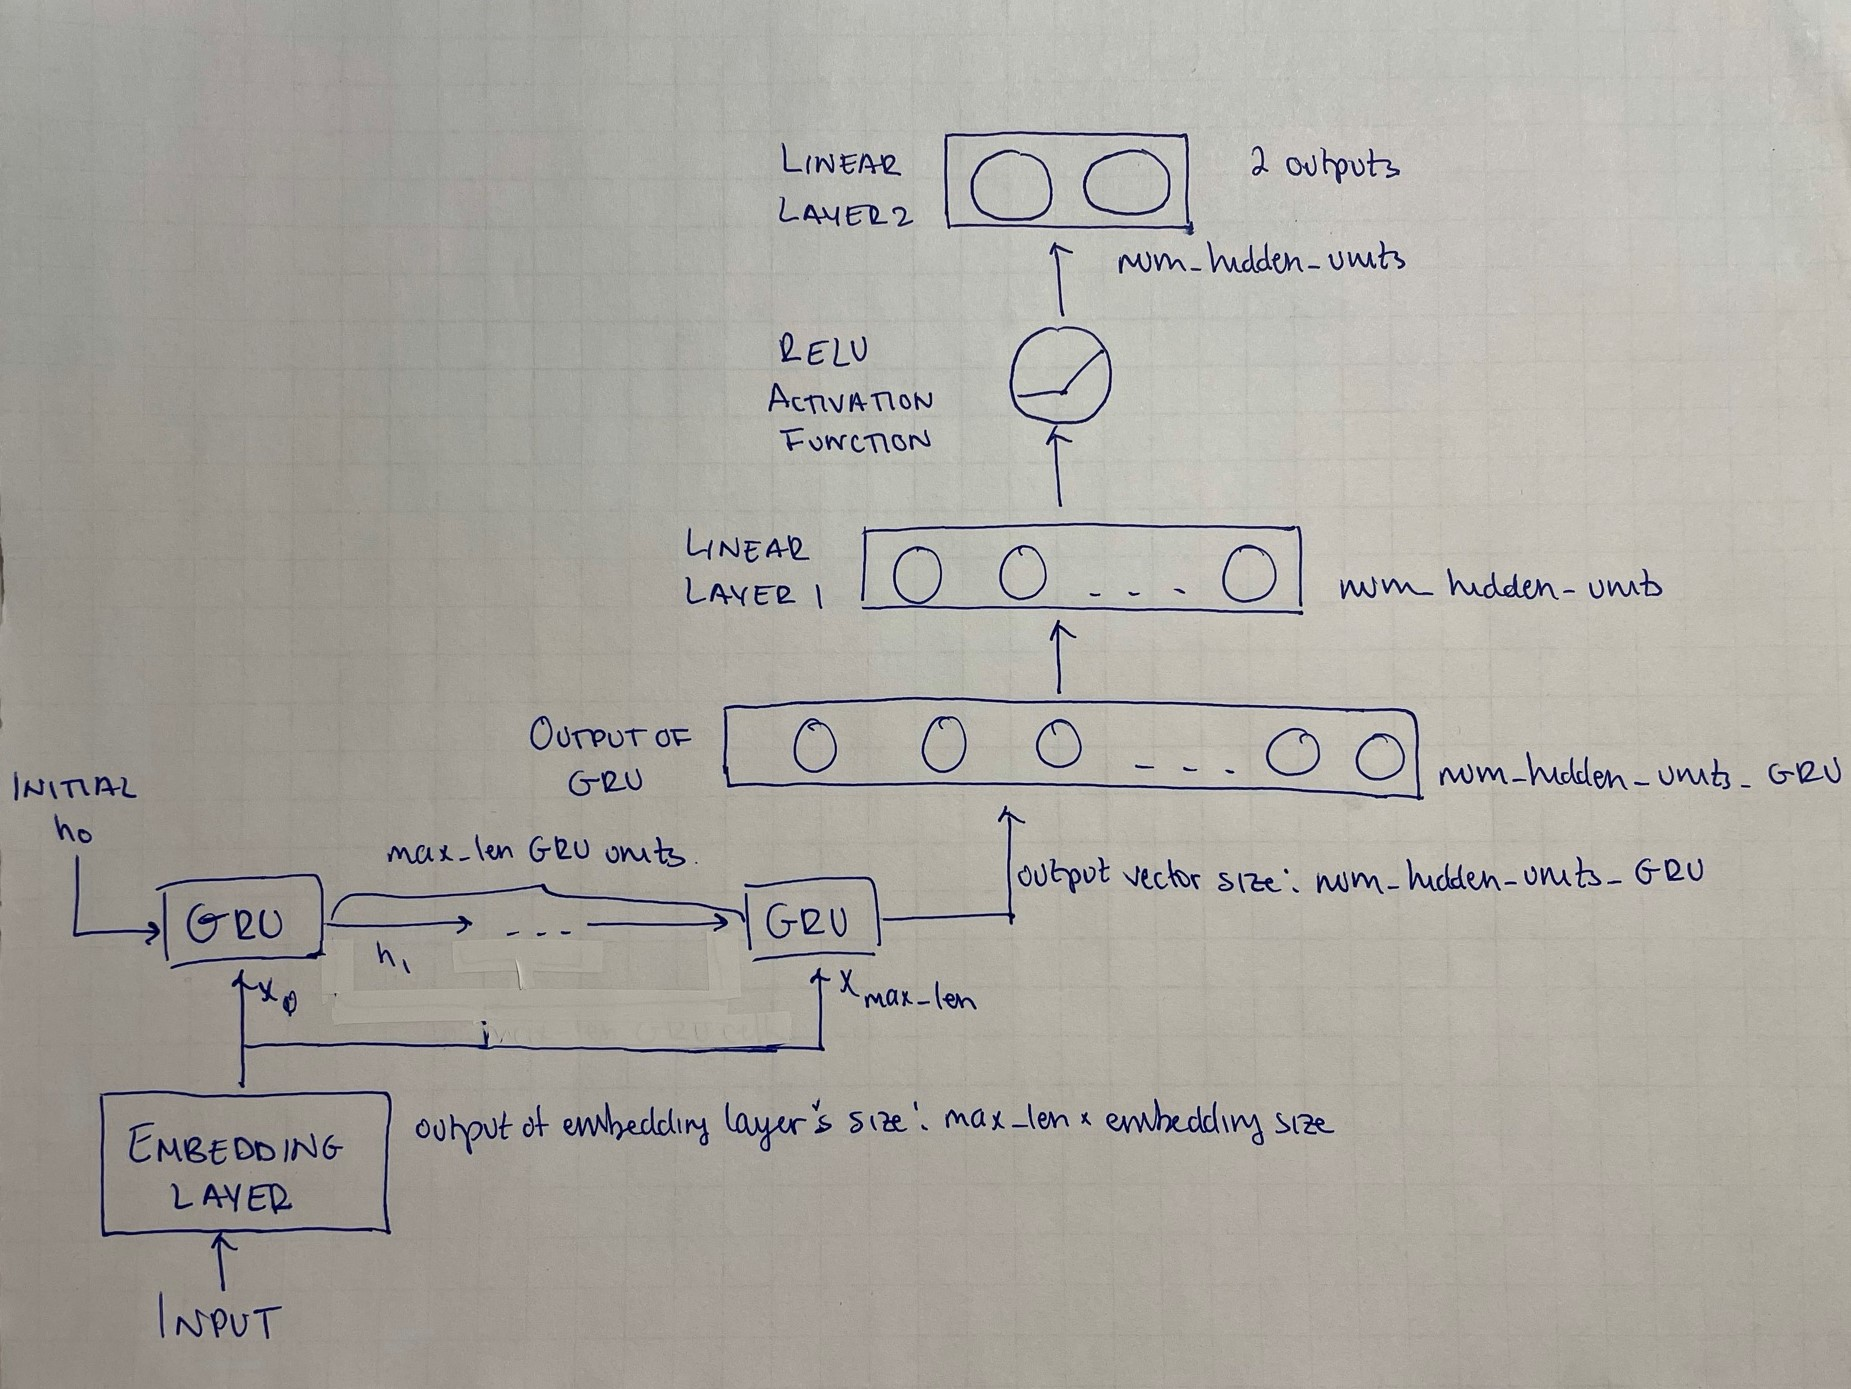

**Question 10**[1 point]: Construct an SGD optimizer using objax optimizers package.

In [12]:
## Your implementaiton of the optimizer should go here
opt = objax.optimizer.SGD(gru_rnn.vars())

Then, we define the loss function, training operation function, and the
evaluation function.

In [13]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv = objax.GradValues(loss_function, gru_rnn.vars())


@objax.Function.with_vars(gv.vars() + opt.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv(x, y)
    opt(lr, g)
    return loss

train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn.vars())


The next function is a helper for computing the accuracy.

In [14]:
def accuracy(data_loader):
    """Compute the accuracy for a provided data loader"""
    acc_total = 0
    x, y = data_loader
    batch_size_acc = 500
    for batch_idx in np.array_split(np.arange(len(x)), len(x) // batch_size_acc):
        x_batch, target_class = x[batch_idx], y[batch_idx]
        predicted_class = eval_op(x_batch).argmax(1)
        acc_total += (predicted_class == target_class).sum()
    return acc_total / len(x)

In [15]:
# helper function to compute the highest accuracy and the epoch where it occurred
def find_highest_acc_and_epoch(a_list):
    highest_acc = max(a_list)
    epoch = a_list.index(highest_acc)

    return highest_acc*100, epoch + 1

**Question 11** [4 points]: Write the training loop to train the model. In each epoch, record the training accuracy and the validation accuracy. Also, at the end of the training report the accuracy on the test set. Please use the training set to train the model, the validation set to monitor accuracy during training, and then the test set once after training is complete to measure the final generalization of the model.

In [16]:
learning_rate = 1e-3 # learning rate
num_epochs = 20 # number of epochs
batch_size = 250  # batch size
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [17]:
def train(EPOCHS = num_epochs, BATCH = batch_size, LEARNING_RATE = learning_rate, SUPPRESS_OUTPUT=False):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  X_train, Y_train = training_data
  X_valid, Y_valid = validation_data

  for epoch in range(EPOCHS):

      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      for batch_idx in np.array_split(np.arange(len(X_train)), len(X_train) // BATCH):
          x_batch_train, target_class = X_train[batch_idx], Y_train[batch_idx]
          avg_train_loss += float(train_op(x_batch_train, target_class, LEARNING_RATE)[0]) * len(x_batch_train)
      
      train_acc = accuracy(training_data)
      train_acc_epoch.append(train_acc)
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])
      
      for batch_idx in np.array_split(np.arange(len(X_valid)), len(X_valid) // BATCH):
          x_batch_valid, target_class = X_valid[batch_idx], Y_valid[batch_idx]
          avg_val_loss += float(loss_function(x_batch_valid, target_class)) * len(x_batch_valid)
          
      val_acc = accuracy(validation_data)
      val_acc_epoch.append(val_acc)
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])
        
      if not SUPPRESS_OUTPUT:
        print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' %\
                (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc, 100*val_acc))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

  return train_acc_epoch, val_acc_epoch

Epoch 0001  Training Loss 173.11 Validation Loss 172.54 Training Accuracy 52.86 Validation Accuracy 54.76
Epoch 0002  Training Loss 172.53 Validation Loss 171.70 Training Accuracy 54.72 Validation Accuracy 55.42
Epoch 0003  Training Loss 171.44 Validation Loss 169.85 Training Accuracy 56.84 Validation Accuracy 56.80
Epoch 0004  Training Loss 169.56 Validation Loss 167.11 Training Accuracy 59.12 Validation Accuracy 58.62
Epoch 0005  Training Loss 167.58 Validation Loss 162.55 Training Accuracy 62.69 Validation Accuracy 62.38
Epoch 0006  Training Loss 165.09 Validation Loss 159.29 Training Accuracy 65.11 Validation Accuracy 64.78
Epoch 0007  Training Loss 163.38 Validation Loss 159.05 Training Accuracy 63.62 Validation Accuracy 63.40
Epoch 0008  Training Loss 160.33 Validation Loss 153.02 Training Accuracy 67.48 Validation Accuracy 67.84
Epoch 0009  Training Loss 158.67 Validation Loss 154.76 Training Accuracy 66.32 Validation Accuracy 66.00
Epoch 0010  Training Loss 157.15 Validation Lo

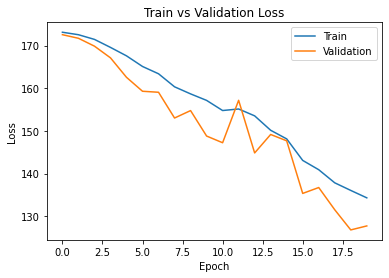

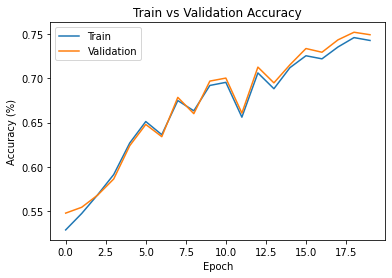

In [18]:
train_acc, val_acc = train()

In [19]:
# find test accuracy of this model
test_acc = accuracy(test_data)

print("Test accuracy of model gru_rnn: {:.2f}%".format(test_acc*100))

Test accuracy of model gru_rnn: 74.94%


**Question 12:[1 points]**  Plot the training accuracy and the validation accuracy versus the number of epochs. What is the generalization gap between the test and training?

See graphs above for plots of the training and validation accuracies as a function of the number of epochs.

In [20]:
# find generalization gap by comparing the best training and validation accuracies with the test accuracy

highest_train_acc, train_epoch = find_highest_acc_and_epoch(train_acc)
highest_val_acc, val_epoch = find_highest_acc_and_epoch(val_acc)

print("Highest training accuracy: {:.2f}% at epoch {}".format(highest_train_acc, train_epoch))
print("Highest validation accuracy: {:.2f}% at epoch {}".format(highest_val_acc, val_epoch))
print("Test accuracy of model gru_rnn: {:.2f}%".format(test_acc*100))

print("\nThe generalization gap (difference between the test accuracy and the training accuracy) is: {:.2f}%"\
      .format(abs(test_acc*100 - highest_train_acc)))

Highest training accuracy: 74.60% at epoch 19
Highest validation accuracy: 75.20% at epoch 19
Test accuracy of model gru_rnn: 74.94%

The generalization gap (difference between the test accuracy and the training accuracy) is: 0.35%


# Comparing SGD with Adam

**Question 13** [4 points]: Train the same model with the same parameters using the Adam optimizer instead of the SGD. Do not forgot to initialize the network before training, otherwise the previous model will continue training from the final model parameters rather than start from a fresh set of random weight initialization values.

In [21]:
# Define (again) your model here
gru_rnn2 = objax.nn.Sequential([
    # embedding layer
    Embed(max_len, embedding_size),

    # GRU layer
    GRU(embedding_size, num_hidden_units_GRU),

    # fully connected layer
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),

    # feed through ReLU activation
    objax.functional.relu,

    # output
    objax.nn.Linear(num_hidden_units, 2),
])

In [22]:
## Your implementaiton of the optimizer should go here
opt2 = objax.optimizer.Adam(gru_rnn2.vars())

You will also need the following functions.

In [23]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv2 = objax.GradValues(loss_function, gru_rnn2.vars())


@objax.Function.with_vars(gv2.vars() + opt2.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv2(x, y)
    opt2(lr, g)
    return loss

train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn2.vars())

In [24]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [25]:
# you code for the training loop should start here 

def train(EPOCHS = num_epochs, BATCH = batch_size, LEARNING_RATE = learning_rate, SUPPRESS_OUTPUT=False):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  X_train, Y_train = training_data
  X_valid, Y_valid = validation_data

  for epoch in range(EPOCHS):

      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      for batch_idx in np.array_split(np.arange(len(X_train)), len(X_train) // BATCH):
          x_batch_train, target_class = X_train[batch_idx], Y_train[batch_idx]
          avg_train_loss += float(train_op(x_batch_train, target_class, LEARNING_RATE)[0]) * len(x_batch_train)
      
      train_acc = accuracy(training_data)
      train_acc_epoch.append(train_acc)
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])
      
      for batch_idx in np.array_split(np.arange(len(X_valid)), len(X_valid) // BATCH):
          x_batch_valid, target_class = X_valid[batch_idx], Y_valid[batch_idx]
          avg_val_loss += float(loss_function(x_batch_valid, target_class)) * len(x_batch_valid)
          
      val_acc = accuracy(validation_data)
      val_acc_epoch.append(val_acc)
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])
        
      if not SUPPRESS_OUTPUT:
        print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' %\
                (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc, 100*val_acc))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

  return train_acc_epoch, val_acc_epoch

**Question 14** [1 points]: Plot the training accuracy and validation accuracy versus the epochs, and compare your results with the case that you trained the network using SGD. What is the generalization gap for this case?

Epoch 0001  Training Loss 158.03 Validation Loss 129.84 Training Accuracy 73.75 Validation Accuracy 74.74
Epoch 0002  Training Loss 130.12 Validation Loss 122.83 Training Accuracy 75.69 Validation Accuracy 76.44
Epoch 0003  Training Loss 128.12 Validation Loss 122.52 Training Accuracy 75.93 Validation Accuracy 76.62
Epoch 0004  Training Loss 129.72 Validation Loss 123.82 Training Accuracy 75.44 Validation Accuracy 76.22
Epoch 0005  Training Loss 128.75 Validation Loss 125.10 Training Accuracy 75.36 Validation Accuracy 75.46
Epoch 0006  Training Loss 129.34 Validation Loss 124.90 Training Accuracy 75.29 Validation Accuracy 75.52
Epoch 0007  Training Loss 128.39 Validation Loss 124.19 Training Accuracy 75.35 Validation Accuracy 75.94
Epoch 0008  Training Loss 126.92 Validation Loss 126.57 Training Accuracy 74.65 Validation Accuracy 75.10
Epoch 0009  Training Loss 124.59 Validation Loss 123.82 Training Accuracy 75.63 Validation Accuracy 75.78
Epoch 0010  Training Loss 122.91 Validation Lo

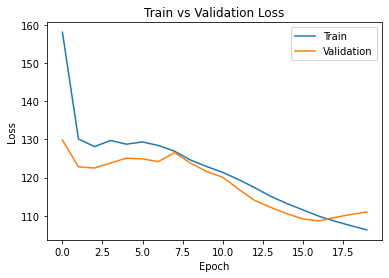

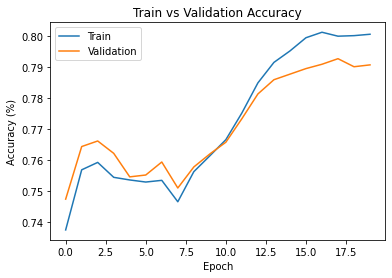

In [26]:
train_acc, val_acc = train()

In [27]:
# find test accuracy of this model
    
test_acc = accuracy(test_data)
print("Test accuracy of model gru_rnn2: {:.2f}%".format(test_acc*100))

Test accuracy of model gru_rnn2: 79.68%


In [28]:
# find generalization gap by comparing the best training and validation accuracies with the test accuracy

highest_train_acc, train_epoch = find_highest_acc_and_epoch(train_acc)
highest_val_acc, val_epoch = find_highest_acc_and_epoch(val_acc)

print("Highest training accuracy: {:.2f}% at epoch {}".format(highest_train_acc, train_epoch))
print("Highest validation accuracy: {:.2f}% at epoch {}".format(highest_val_acc, val_epoch))
print("Test accuracy of model gru_rnn2: {:.2f}%".format(test_acc*100))

print("\nThe generalization gap (difference between the test accuracy and the training accuracy) is: {}"\
      .format(abs(test_acc*100 - highest_train_acc)))

Highest training accuracy: 80.14% at epoch 17
Highest validation accuracy: 79.28% at epoch 18
Test accuracy of model gru_rnn2: 79.68%

The generalization gap (difference between the test accuracy and the training accuracy) is: 0.4550018310546875


The model which uses the Adam optimizer achieves a higher test accuracy than the model which uses the SGD optimizer. In addition, the training loop runs faster when using the Adam optimizer (empirically determined).

**Questions 15** [1 points]: Briefly explain how Adam optimizer works and compare it with the SGD optimizer.

**Adam Optimizer Optimization Routine**

Adam is a variation on SGD which uses adaptive estimation of first-order (the gradient) and second-order (the squared gradient) moments to update the parameters. Compared to SGD, Adam converges faster because it keeps track of the history of the gradients.

The Adam algorithm first computes the gradient $g_{t}$ of the loss function with respect to the weights, and then it computes and remembers the first and second order moments of the gradient $m_{t}$ and $v_{t}$, respectively. This is shown in the following equations:

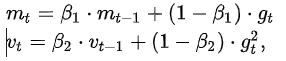

$\beta_{1}$ and $\beta_{2}$, are hyperparameters which control the exponential decay rates of the first and second moments, respectively. Their values are between 0 and 1.

Initially, both $m_{0}$ and $v_{0}$ are initialized to 0, so the values $m_{t}$ and $v_{t}$ are biased towards 0 at small timesteps $t$. To counter this, the Adam optimizer's authors proposed a corrected update to $m_{t}$ and $v_{t}$, which is as follows: 

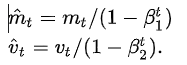

The weight update rule is computed as 

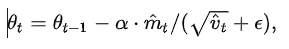

where $ϵ$ is a small constant to prevent division by 0 (and thus to increase computational stability).

**References**

https://objax.readthedocs.io/en/latest/objax/optimizer.html#objax.optimizer.Adam

https://arxiv.org/abs/1412.6980

https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam

https://optimization.cbe.cornell.edu/index.php?title=Adam

# Early Stopping

**Questions 16** [3 points]: 
This time implement the early stopping method with a patience window. All the parameters are the same as the previous section. Also, set the patience window to 5 epochs.

In [71]:
# Your implementation of the model should go here
gru_rnn3 = objax.nn.Sequential([
    # embedding layer
    Embed(max_len, embedding_size),

    # GRU layer
    GRU(embedding_size, num_hidden_units_GRU),

    # fully connected layer
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),

    # feed through ReLU activation
    objax.functional.relu,

    # output
    objax.nn.Linear(num_hidden_units, 2),
])

In [72]:
## Your implementation of the optimizer should go here
opt3 = objax.optimizer.Adam(gru_rnn3.vars())

You will also need the following functions.

In [73]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv3 = objax.GradValues(loss_function, gru_rnn3.vars())


@objax.Function.with_vars(gv3.vars() + opt3.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv3(x, y)
    opt3(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn3.vars())

In [74]:
learning_rate = 1e-2
num_epochs = 20
batch_size = 250 
max_patience_window = 5
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [75]:
# you code for the training loop should start here 

def train(EPOCHS = num_epochs, BATCH = batch_size, LEARNING_RATE = learning_rate, SUPPRESS_OUTPUT=False):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  X_train, Y_train = training_data
  X_valid, Y_valid = validation_data
  
  best_val_loss = None
  best_val_loss_epoch = None
  best_val_acc = None
  best_val_acc_epoch = None
  number_of_bad_epochs = 0

  test_acc = None

  for epoch in range(EPOCHS):
      #print("Epoch number: {}".format(epoch))

      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      for batch_idx in np.array_split(np.arange(len(X_train)), len(X_train) // BATCH):
          x_batch_train, target_class = X_train[batch_idx], Y_train[batch_idx]
          avg_train_loss += float(train_op(x_batch_train, target_class, LEARNING_RATE)[0]) * len(x_batch_train)
      
      train_acc = accuracy(training_data)
      train_acc_epoch.append(train_acc)
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])
      
      for batch_idx in np.array_split(np.arange(len(X_valid)), len(X_valid) // BATCH):
          x_batch_valid, target_class = X_valid[batch_idx], Y_valid[batch_idx]
          avg_val_loss += float(loss_function(x_batch_valid, target_class)) * len(x_batch_valid)
          
      val_acc = accuracy(validation_data)
      val_acc_epoch.append(val_acc)
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])
        
      if not SUPPRESS_OUTPUT:
        print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' %\
                (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc, 100*val_acc))
      
      # early stopping version 1 using loss and consecutive window
      # if loss keeps decreasing, reset the number of bad epochs counter
      # if the loss doesn't improve, then we wait 5 epochs before breaking out of the training function
      # keep track of the best val loss and the epoch where it occurred
      ''' val_loss = avg_val_loss/X_valid.shape[0]
      if best_val_loss is None or val_loss < best_val_loss:
          best_val_loss = val_loss
          best_val_loss_epoch = epoch
          number_of_bad_epochs = 0
          test_acc = accuracy(test_data)
      else:
          number_of_bad_epochs += 1

      if number_of_bad_epochs >= max_patience_window:
          print("*** Early stopping triggered ***")
          print("Exiting training loop after epoch {} because validation loss has not improved from {:.2f} (achieved at epoch {}) for {} epochs"\
                .format(epoch+1, best_val_loss, best_val_loss_epoch+1, max_patience_window))
          break'''

      # early stopping version 2 using accuracy and non-consecutive window
      if best_val_acc == None:
          best_val_acc = val_acc
      elif val_acc <= best_val_acc:
          number_of_bad_epochs += 1
      else:
          best_val_acc_epoch = epoch
          best_val_acc = val_acc
          test_acc = accuracy(test_data)

      
      if number_of_bad_epochs >= max_patience_window:
          print("*** Early stopping triggered ***")
          print("Exiting training loop after epoch {} because validation loss has not improved from {:.2f} (achieved at epoch {}) for {} epochs"\
                .format(epoch+1, best_val_acc, best_val_acc_epoch+1, max_patience_window))
          break

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

  return train_acc_epoch, val_acc_epoch, best_val_acc, best_val_acc_epoch, test_acc

Epoch 0001  Training Loss 150.16 Validation Loss 125.04 Training Accuracy 74.63 Validation Accuracy 75.92
Epoch 0002  Training Loss 127.17 Validation Loss 118.54 Training Accuracy 76.33 Validation Accuracy 76.56
Epoch 0003  Training Loss 120.73 Validation Loss 110.46 Training Accuracy 78.91 Validation Accuracy 79.02
Epoch 0004  Training Loss 114.14 Validation Loss 106.72 Training Accuracy 80.44 Validation Accuracy 79.86
Epoch 0005  Training Loss 108.81 Validation Loss 105.02 Training Accuracy 81.28 Validation Accuracy 79.92
Epoch 0006  Training Loss 104.78 Validation Loss 105.11 Training Accuracy 82.16 Validation Accuracy 80.04
Epoch 0007  Training Loss 100.77 Validation Loss 107.90 Training Accuracy 82.84 Validation Accuracy 80.10
Epoch 0008  Training Loss 97.71 Validation Loss 110.52 Training Accuracy 83.66 Validation Accuracy 80.24
Epoch 0009  Training Loss 95.18 Validation Loss 113.82 Training Accuracy 83.82 Validation Accuracy 79.54
Epoch 0010  Training Loss 93.65 Validation Loss 

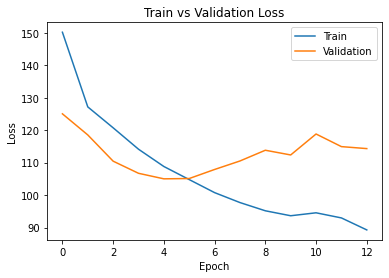

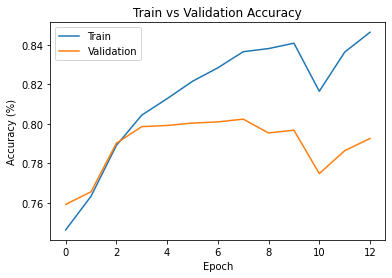

In [76]:
train_acc, val_acc, best_val_acc, best_val_acc_epoch, test_acc = train()

A note on early stopping: In order to trigger early stopping in my training loop above, I had to do some hyperparameter tuning (namely, increasing the learning rate from 1e-3 -> 1e-2). This triggered early stopping after 11 epochs. With the default number of epochs and learning rate, early stopping wouldn't be triggered after 20 epochs. 

**Question 17**[1 points]: Report the best validation accuracy and the test accuracy of your best model.

The model with the highest training and validation accuacies is the model gru_rnn3, so gru_rnn3 is the best model. The highest validation accuracy and test accuracy of this model were calculated above, so we can re-use these values.

In [77]:
#highest_val_acc, val_epoch = find_highest_acc_and_epoch(val_acc)

print("Highest validation accuracy: {:.2f}% at epoch {}".format(best_val_acc*100, best_val_acc_epoch))
print("Test accuracy of best model: {:.2f}%".format(test_acc*100))

Highest validation accuracy: 80.24% at epoch 7
Test accuracy of best model: 80.80%


In [78]:
highest_train_acc, train_epoch = find_highest_acc_and_epoch(train_acc)
#highest_val_acc, val_epoch = find_highest_acc_and_epoch(val_acc)

print("Highest training accuracy: {:.2f}% at epoch {}".format(highest_train_acc, train_epoch))
print("Highest validation accuracy: {:.2f}% at epoch {}".format(best_val_acc*100, best_val_acc_epoch,))
print("Test accuracy of best model: {:.2f}%".format(test_acc*100))

print("\nThe generalization gap (difference between the test accuracy and the training accuracy) is: {}"\
      .format(abs(test_acc*100 - highest_train_acc)))

Highest training accuracy: 84.64% at epoch 13
Highest validation accuracy: 80.24% at epoch 7
Test accuracy of best model: 80.80%

The generalization gap (difference between the test accuracy and the training accuracy) is: 3.842498779296875
